# Project B: Eigenvalue Problem with PINNs
Karin Yu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.nn import Sequential, Linear, ReLU, Tanh
from torch.utils.data import DataLoader
import copy
import time
torch.autograd.set_detect_anomaly(True)

In [2]:
class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

In [127]:
class Pinns:
    def __init__(self, n_int_, n_sb_, L, num_modes_, tol_PDE_, tol_deltaPDE):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.v_norm = 1
        self.v_orth = 1
        
        # Parameters
        self.L = L
        self.num_modes = num_modes_
        self.lambda_ortho = 50
        
        # Tolerances / Thresholds for L_PDE
        self.tol_PDE = tol_PDE_
        self.tol_dPDE = tol_deltaPDE
        
        # Extrema of the solution domain 
        self.domain_extrema = torch.tensor([[0, self.L]])  # Space dimension 0, L
        
        # Number of space dimensions
        self.space_dimensions = 1
        
        # Activation Function
        self.activation = SinActivation()
        
        # Forward Dense NN to approximate the solution of the underlying heat equation
        self.approximate_N1 = Sequential(Linear(2,20), self.activation, Linear(20,20), self.activation)
        self.approximate_N2 = Sequential(Linear(2,20), self.activation, Linear(20,20), self.activation)
        self.approximate_N = Sequential(Linear(20,20), self.activation, Linear(20,1))
        self.even = True
        
        self.approximate_lambda = Sequential(Linear(10,1))
        
        # Initialize weights:
        torch.manual_seed(42)
        g = torch.nn.init.calculate_gain('tanh')
        #torch.nn.init.xavier_uniform_(self.approximate_lambda.weight, gain = g)
        self.approximate_lambda.apply(self.init_weights)
        torch.manual_seed(42)
        self.approximate_N1.apply(self.init_weights)
        torch.manual_seed(42)
        self.approximate_N2.apply(self.init_weights)
        torch.manual_seed(42)
        self.approximate_N.apply(self.init_weights)
        
        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])
        
        # Training sets S_sb, S_int as torch dataloader
        self.training_set_sb, self.training_set_int = self.assemble_datasets()
        
        # Initialize eigenfunction and eigenvalues
        self.eigenfunction = torch.zeros((n_int_,1))
        self.eigenvalues = []
        
        # Initialize history
        self.history_PDE = []
        self.history_lambda = []
        self.lambda_PDE_ortho = 20
        
        # Initialize models:
        self.model_lambda = []
        self.model_N = []
        
    def init_weights(self,m):
        torch.manual_seed(42)
        if type(m) == torch.nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = torch.nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain = g)
            m.bias.data.fill_(0)
        
    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]
    
    # Boundary condition 
    def boundary_condition(self, inp):
        return torch.zeros(inp.size)
    
    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[0, 0]
        xL = self.domain_extrema[0, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb)) #transform random points between extrema

        input_sb_0 = torch.clone(input_sb)
        input_sb_0 = torch.full(input_sb_0.shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L = torch.full(input_sb_L.shape, xL)

        # for u
        output_sb_0 = torch.zeros((input_sb_0.shape[0], 1)) # we have 0 Dirichlet BC
        output_sb_L = torch.zeros((input_sb_L.shape[0], 1))
        # Input is size 2*n_sb x 2
        # Output is size 2*n_sb x output_dim
        return torch.cat([input_sb_0, input_sb_L], 0).to(dtype=torch.float32), torch.cat([output_sb_0, output_sb_L],0).to(dtype=torch.float32)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=self.space_dimensions*self.n_sb, shuffle=True)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=True)

        return training_set_sb,training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb, m):
        input_sb.requires_grad = True
        X = self.approximate_solution(input_sb)
        u_pred = X[:,0]
        return u_pred

    def approximate_solution(self, inpt):
        inpt.requires_grad = True
        lmbd = self.approximate_lambda(torch.ones((10)))*torch.ones(inpt.shape)
        inpt_ext1 = torch.cat([inpt, lmbd*torch.ones(inpt.shape)],1)
        inpt_ext2 = torch.cat([-1*inpt, lmbd*torch.ones(inpt.shape)],1)
        if self.even:
            N0 = self.approximate_N1(inpt_ext1) + self.approximate_N2(inpt_ext2)
        else:
            N0 = self.approximate_N1(inpt_ext1) - self.approximate_N2(inpt_ext2)
        N = self.approximate_N(N0)
        g = self.parametric_function(inpt)
        return g*N
    
    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int, m):
        input_int.requires_grad = True # gradients are tracked so that they can be used for backpropagation
        X = self.approximate_solution(input_int)
        u = X[:,0]
        
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_x = grad_u[:,0]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 0]

        lmbd = self.approximate_lambda(torch.ones((10)))
        
        residual = grad_u_xx + lmbd**2 * u
        return residual
    
    def compute_norm_loss(self,input_int, m):
        input_int.requires_grad = True # gradients are tracked so that they can be used for backpropagation
        X = self.approximate_solution(input_int)
        u = X[:,0]
        lmbd = self.approximate_lambda(torch.ones((10)))
        return ((torch.inner(u,u) - self.n_int/self.L)**2) #torch.sum
        
    def compute_ortho_loss(self, input_int, m):
        input_int.requires_grad = True # gradients are tracked so that they can be used for backpropagation
        X = self.approximate_solution(input_int)
        N = self.eigenfunction[:,0]
        for i in range(1, m):
            N = N+self.eigenfunction[:,i]
        u = X[:,0]
        return torch.dot(N,u)
    
    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, T_train_sb, inp_train_int, verbose=True):
        # BC
        loss_sb = torch.FloatTensor([0])
        loss_int = torch.FloatTensor([0])
        loss_norm = torch.FloatTensor([0])
        loss_ortho = torch.FloatTensor([0])
        for i in range(1, self.num_modes + 1):
            r_int = self.compute_pde_residual(inp_train_int, i)
            loss_int = loss_int + torch.mean(abs(r_int) ** 2)
            u_pred_sb = self.apply_boundary_conditions(inp_train_sb, i)
            r_u_sb = T_train_sb - u_pred_sb # x = x0, x = xL
            loss_sb = loss_sb + torch.mean(abs(r_u_sb) ** 2)
            loss_norm = loss_norm+self.compute_norm_loss(inp_train_int, i)
            loss_ortho = loss_ortho+abs(self.compute_ortho_loss(inp_train_int, i))
            
        self.history_PDE.append(loss_int.item())
        lmbd = self.approximate_lambda(torch.ones((10)))
        self.history_lambda.append(lmbd.item())

        loss_T = (loss_sb + loss_int + loss_norm + self.lambda_ortho*loss_ortho)

        loss = loss_T# + loss_lambda #log leads to negative loss
        if verbose: print("Norm Loss: {:.4f} | Ortho Loss: {:.4f} | PDE Loss: {:.4f} | Total Loss: {:.4f} ".format(loss_norm.item(), loss_ortho.item(),loss_int.item(), loss_T.item()))# | Lambda Loss: {:.4f} , loss_lambda.item()

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, scheduler = None, step = None, model_save_path: str = '', model_load_path: str = '', verbose=True):
        history = list()
        
        if len(model_load_path) > 0:
            # load model
            checkpoint = torch.load(model_load_path)
            self.approximate_N.load_state_dict(checkpoint['approximate_N_state_dict'])
            self.approximate_lambda.load_state_dict(checkpoint['approximate_lambda_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.eigenfunction = checkpoint['eigenfunctions']
            self.eigenvalues = checkpoint['eigenvalues']
            self.num_modes = len(self.eigenvalues)+1
        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose and epoch % 5 == 0: print("################################ ", epoch, " ################################")

            plotbool = epoch % 5 == 0
            for j, ((inp_train_sb, T_train_sb),  (inp_train_int, T_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, T_train_sb, torch.sort(inp_train_int[:,0])[0].unsqueeze(-1), verbose=plotbool)
                    loss.backward()
                    history.append(loss.item())
                    return loss
                
                optimizer.step(closure = closure)
                
            if epoch % step == 0: 
                #scheduler.step()
                self.lambda_ortho = 0.98*self.lambda_ortho
                    
            if epoch > 1:
                if self.history_PDE[-1] < self.tol_PDE:# and abs(self.history_PDE[-2]-self.history_PDE[-1]) < self.tol_dPDE:
                    self.model_lambda.append(copy.deepcopy(self.approximate_lambda))
                    self.model_N.append([copy.deepcopy(self.even), copy.deepcopy(self.approximate_N1),copy.deepcopy(self.approximate_N2),copy.deepcopy(self.approximate_N)])
                    print("Change of modes")
                    for j, ((inp_train_sb, T_train_sb),  (inp_train_int, T_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_int)):
                        self.eigenfunction = torch.cat((self.eigenfunction, self.predict(torch.sort(inp_train_int[:,0])[0].unsqueeze(-1), mode = self.num_modes)), dim = -1).detach()
                        self.eigenvalues.append(self.approximate_lambda(torch.ones((10))))
                    self.num_modes = self.num_modes + 1 
                    torch.manual_seed(42)
                    self.approximate_lambda.apply(self.init_weights)
                    torch.manual_seed(42)
                    self.approximate_N1.apply(self.init_weights)
                    torch.manual_seed(42)
                    self.approximate_N2.apply(self.init_weights)
                    torch.manual_seed(42)
                    self.approximate_N.apply(self.init_weights)
                    optimizer.param_groups[0]['lr'] = float(0.05)
                    #scheduler.step()
                    self.lambda_ortho = max(50-5*self.num_modes,5)
                    self.lambda_PDE_ortho = self.lambda_PDE_ortho/2
                elif abs(self.history_PDE[-2]-self.history_PDE[-1]) < self.tol_dPDE/10:
                    # Change symmetry
                    print("Change of symmetry")
                    #if optimizer_ADAM.param_groups[0]['lr'] < 0.019:
                    #    optimizer.param_groups[0]['lr'] = float(0.02)
                    #scheduler.step()
                    self.lambda_ortho = max(50-5*self.num_modes,3)
                    if self.even:
                        self.even = False
                    else:
                        self.even = True
            
            if epoch > 1: print('Current change in loss_PDE: {:.5f} \nCurrent Learning rate: {:.8f}\nCurrent lambda: {:.3f}'.format(abs(self.history_PDE[-2]-self.history_PDE[-1]),scheduler.get_last_lr()[0], self.history_lambda[-1]))

        print('Final Loss: ', history[-1])
        
        if len(model_save_path) > 0:
            # save model
            torch.save({'approximate_N_state_dict': self.approximate_N.state_dict(), 'approximate_lambda_state_dict': self.approximate_lambda.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'eigenvalues': self.eigenvalues,'eigenfunctions': self.eigenfunction}, model_save_path)

        return history

    def parametric_function(self, inpt):
        return (1-torch.exp(-(inpt))) * (1-torch.exp(-(inpt-torch.ones(inpt.shape)*self.L)))
  
    def predict(self, inpt, mode = 1):
        lmbd = self.approximate_lambda(torch.ones((10)))*torch.ones(inpt.shape)
        inpt_ext1 = torch.cat([inpt, lmbd*torch.ones(inpt.shape)],1)
        inpt_ext2 = torch.cat([-1*inpt, lmbd*torch.ones(inpt.shape)],1)
        if self.even:
            N0 = self.approximate_N1(inpt_ext1) + self.approximate_N2(inpt_ext2)
        else:
            N0 = self.approximate_N1(inpt_ext1) - self.approximate_N2(inpt_ext2)
        N = self.approximate_N(N0)
        g = self.parametric_function(inpt)
        return g*N
    
    def predict_with_model(self, model_lambda, model_N, inpt):
        lmbd = model_lambda(torch.ones((10)))*torch.ones(inpt.shape)
        inpt_ext1 = torch.cat([inpt, lmbd*torch.ones(inpt.shape)],1)
        inpt_ext2 = torch.cat([-1*inpt, lmbd*torch.ones(inpt.shape)],1)
        if model_N[0]:
            N0 = model_N[1](inpt_ext1) + model_N[2](inpt_ext2)
        else:
            N0 = model_N[1](inpt_ext1) - model_N[2](inpt_ext2)
        N = model_N[3](N0)
        g = self.parametric_function(inpt)
        return lmbd, g*N # eigenvalue, eigenfunction
        


In [128]:
# Set manual seed
torch.manual_seed(128)

In [150]:
# Initialize PINN
n_int = 100
n_sb = 24
L = 1

In [151]:
pinn = Pinns(n_int, n_sb, L, 1, 1, 1e-3) #num_modes
histo = []

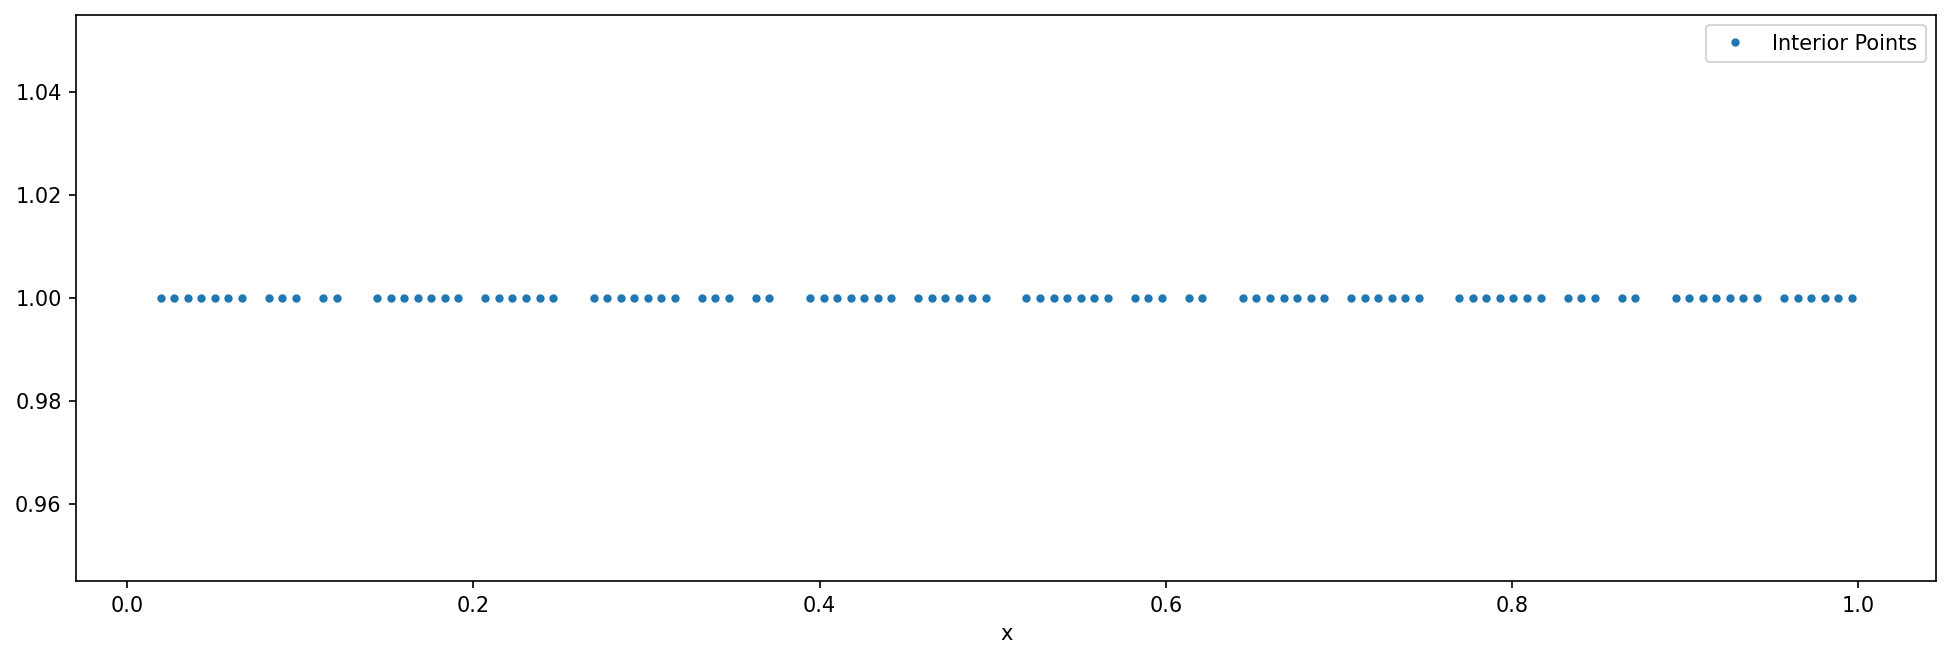

In [152]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 5), dpi=150)
plt.plot(input_int_[:, 0].detach().numpy(),np.ones((n_int,1)), '.',label="Interior Points")
plt.xlabel("x")
plt.legend()
plt.show()

In [153]:
params = list(pinn.approximate_N1.parameters()) + list(pinn.approximate_N2.parameters()) + list(pinn.approximate_N.parameters()) + list(pinn.approximate_lambda.parameters())
optimizer_ADAM = optim.Adam(params,
                            lr=float(0.02))
optimizer_LBFGS= optim.LBFGS(params, max_iter = 25, line_search_fn='strong_wolfe')
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer_ADAM, gamma=0.96,last_epoch=-1)
lr_step = 250

In [190]:
%%time
histo.extend(pinn.fit(num_epochs=100,
                optimizer=optimizer_LBFGS, scheduler = lr_scheduler, step = lr_step, model_save_path = "model/T7_400.pth", model_load_path = "model/T7_300.pth",
                verbose=True))

################################  0  ################################
Norm Loss: 18790.5234 | Ortho Loss: 45.1156 | PDE Loss: 215.3832 | Total Loss: 20553.3711 
Norm Loss: 9055.4609 | Ortho Loss: 72.4471 | PDE Loss: 488.4420 | Total Loss: 12028.8398 
Norm Loss: 6966.7363 | Ortho Loss: 115.7414 | PDE Loss: 223.2178 | Total Loss: 11159.8828 
Norm Loss: 8875.5322 | Ortho Loss: 118.3869 | PDE Loss: 1989.5181 | Total Loss: 14925.7227 
Norm Loss: 1922.3672 | Ortho Loss: 161.9806 | PDE Loss: 883.6174 | Total Loss: 8361.9199 
Norm Loss: 625.1154 | Ortho Loss: 147.7878 | PDE Loss: 899.4401 | Total Loss: 6593.6768 
Norm Loss: 34.3928 | Ortho Loss: 123.9174 | PDE Loss: 905.7883 | Total Loss: 5190.5469 
Norm Loss: 334.8134 | Ortho Loss: 109.6855 | PDE Loss: 960.7535 | Total Loss: 5057.7793 
Norm Loss: 335.6292 | Ortho Loss: 109.0704 | PDE Loss: 966.3113 | Total Loss: 5043.0537 
Norm Loss: 326.7129 | Ortho Loss: 107.9668 | PDE Loss: 985.0640 | Total Loss: 5015.0366 
Norm Loss: 291.6990 | Ortho Loss

Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
################################  15  ################################
Norm Loss: 316.1652 | Ortho Loss: 65.0756 | PDE Loss: 2969.3389 | Total Loss: 5563.1514 
Norm Loss: 4687.5771 | Ortho Loss: 138.6769 | PDE Loss: 6519.1978 | Total Loss: 16060.4668 
Norm Loss: 3.9610 | Ortho Loss: 96.5225 | PDE Loss: 8011.0225 | Total Loss: 11393.2725 
Norm Loss: 337.6571 | Ortho Loss: 67.5462 | PDE Loss: 3194.4312 | Total Loss: 5896.2070 
Norm Loss: 318.5286 | Ortho Loss: 65.3237 | PDE Loss: 2991.2183 | Total Loss: 5596.0767 
Norm Loss: 316.2516 | Ortho Loss: 65.0855 | PDE Loss: 2970.2263 | Total Loss: 5564.4692 
Norm Loss: 316.1680 | Ortho Loss: 65.0763 | PDE Loss: 2969.4226 | Total Loss: 5563.2612 
Norm Loss: 316.1675 | Ort

Norm Loss: 316.1656 | Ortho Loss: 65.0756 | PDE Loss: 2969.3396 | Total Loss: 5563.1523 
Norm Loss: 316.1652 | Ortho Loss: 65.0756 | PDE Loss: 2969.3389 | Total Loss: 5563.1514 
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
################################  45  ################################
Norm Loss: 316.1652 | Ortho Loss: 65.0756 | PDE Loss: 2969.3389 | Total Loss: 5563.1514 
Norm Loss: 4687.5771 | Ortho Loss: 138.6769 | PDE Loss: 6519.1978 | Total Loss: 16060.4668 
Norm Loss: 3.9610 | Ortho Loss: 96.5225 | PDE Loss: 8011.0225 | Total Loss: 11393.2725 
Norm Loss: 337.65

Norm Loss: 316.2516 | Ortho Loss: 65.0855 | PDE Loss: 2970.2263 | Total Loss: 5564.4692 
Norm Loss: 316.1680 | Ortho Loss: 65.0763 | PDE Loss: 2969.4226 | Total Loss: 5563.2612 
Norm Loss: 316.1675 | Ortho Loss: 65.0754 | PDE Loss: 2969.3472 | Total Loss: 5563.1533 
Norm Loss: 316.1656 | Ortho Loss: 65.0756 | PDE Loss: 2969.3396 | Total Loss: 5563.1523 
Norm Loss: 316.1652 | Ortho Loss: 65.0756 | PDE Loss: 2969.3389 | Total Loss: 5563.1514 
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
Current change in loss_PDE: 0.00073 
Current Learning rate: 0.02000000
Current lambda: 2.335
################################  75  ################################
Norm Loss: 316.1652

(0.0, 10000.0)

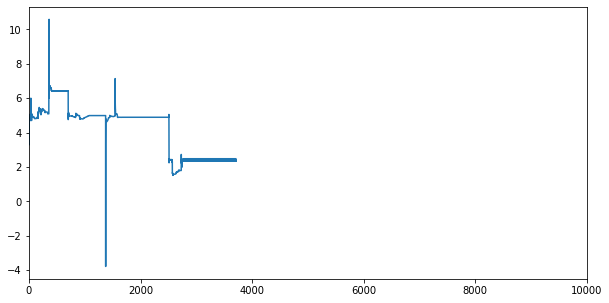

In [194]:
plt.figure(figsize = (10,5))
plt.plot(range(len(pinn.history_lambda)), pinn.history_lambda)
#plt.ylim([0,10])
plt.xlim([0,10000])

True lambda:  9.42477796076938 
Approximated lambda:  2.3353608


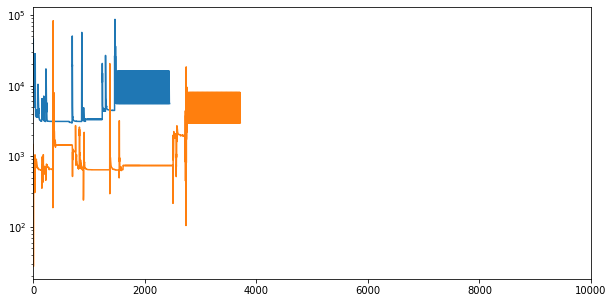

In [192]:
x = np.linspace(0,L,50)
Input_Pred = torch.tensor(x).to(dtype=torch.float32)[:,None]
#Input_Pred = torch.cat([Input_Pred[:,None], pinn.approximate_lambda(torch.FloatTensor([1]))*torch.ones([x.size,1])],1)
print('True lambda: ', np.pi*pinn.num_modes/pinn.L, '\nApproximated lambda: ',pinn.approximate_lambda(torch.ones((10))).detach().numpy()[0])
      
plt.figure(figsize = (10,5))
plt.plot(range(len(histo)), histo)
plt.plot(range(len(pinn.history_PDE)), pinn.history_PDE)
plt.xlim([0,10000])
plt.yscale("log")

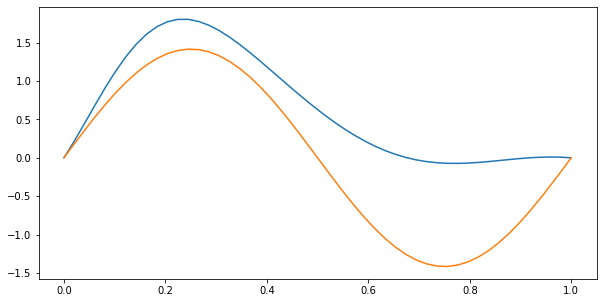

In [193]:
plt.figure(figsize = (10,5))
X = pinn.predict(Input_Pred)
plt.plot(x,X.detach().numpy())
plt.plot(x,np.sqrt(2/L)*np.sin((1+1)*np.pi/L*x), label = 'True, mode '+str(i)) # 1. Mode

In [186]:
l = [0]*len(pinn.model_lambda)
pred = [0]*len(pinn.model_lambda)
for i in range(len(pinn.model_lambda)):
    l[i],pred[i] = pinn.predict_with_model(pinn.model_lambda[i], pinn.model_N[i], Input_Pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


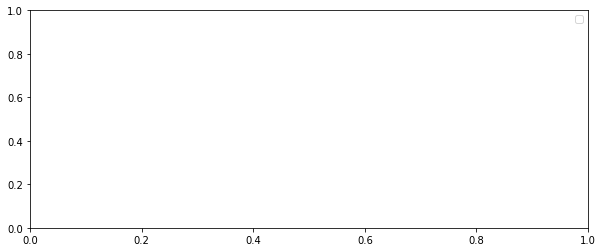

In [187]:
# Plot truth
plt.figure(figsize=(10,4))
for i in range(len(pinn.model_lambda)):
    plt.plot(x,np.sqrt(2/L)*np.sin((i+1)*np.pi/L*x), label = 'True, mode '+str(i)) # 1. Mode
    plt.plot(x,pred[i].detach().numpy(), label = 'Prediction, mode '+str(i))
plt.legend()

[tensor([3.1413], requires_grad=True), tensor([6.2472], requires_grad=True)]